In [1]:
import cloudscraper
from bs4 import BeautifulSoup as soup
import pandas as pd
import numpy as np
from datetime import datetime
import time
import re
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
scraper = cloudscraper.CloudScraper()  # returns a CloudScraper instance
# Or: scraper = cloudscraper.CloudScraper()  # CloudScraper inherits from requests.Session

# Main Page Iteration

In [146]:
STANDARD = ['anime/','book/','cartoon/','comic/','game/','misc/','movie/','play/','tv/']
CROSSOVER = ['crossovers/' + temp for temp in STANDARD]

df = pd.DataFrame({'fandom':[],
                   'count':[],
                   'type':[],
                   'href':[]})
for i in range(len(STANDARD)):
    TYPE_HTML = soup(scraper.get("https://www.fanfiction.net/"+STANDARD[i]).text)
    typetext = STANDARD[i][:-1]
    #print(typetext)
    
    x = TYPE_HTML.find("div", {"id":"list_output"})
    FANDOM = [h.get('title') for h in x.find_all('a')]
    NUM = [h.text[1:-1] for h in x.find_all('span')
           if bool(re.match('[0-9]+K?',h.text[1:-1]))]
    HREF = [h.get('href') for h in x.find_all('a')]
    
    #print(FANDOM[0],NUM[0],HREF[0])
    
    dfi = pd.DataFrame({'fandom':FANDOM,
                   'count':NUM,
                   'type':[typetext for x in range(len(FANDOM))],
                   'href':HREF})
    
    df = df.append(dfi)
    
    time.sleep(1.5)

df["count"] = df["count"].replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)
df = df[df['count']>=30].sort_values('count',ascending=False).reset_index(drop=True)

In [137]:
df = pd.read_csv("fandomstats.csv", index_col=0)

In [139]:
df.head(5)

,fandom,count,type,href
0,Harry Potter,836000,book,/book/Harry-Potter/
1,Naruto,436000,anime,/anime/Naruto/
2,Twilight,221000,book,/book/Twilight/
3,Supernatural,126000,tv,/tv/Supernatural/
4,Inuyasha,121000,anime,/anime/Inuyasha/


<AxesSubplot:ylabel='fandom'>

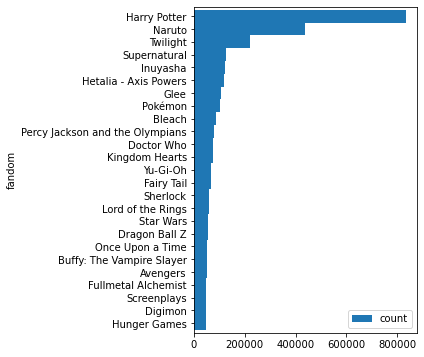

In [140]:
df.head(25).sort_values('count',ascending=True).plot.barh(x='fandom',y='count',figsize=(4,6),width=1)

<AxesSubplot:>

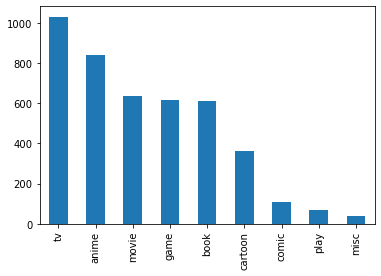

In [141]:
df.type.value_counts().plot.bar()

In [142]:
df.loc[df['count']<=df.loc[100]['count'],'fandom'] = 'Other'

In [143]:
dfOTHER = df.groupby(['type','fandom'],as_index=False).agg('sum').set_index('fandom')

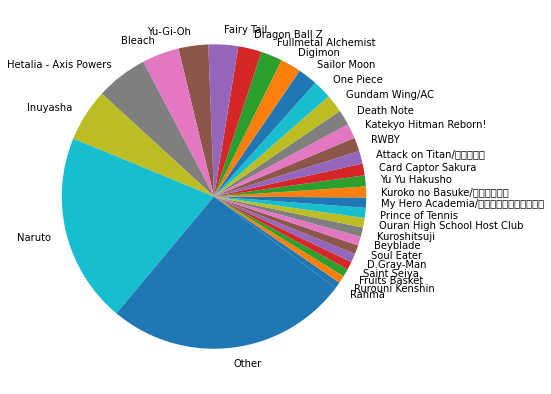

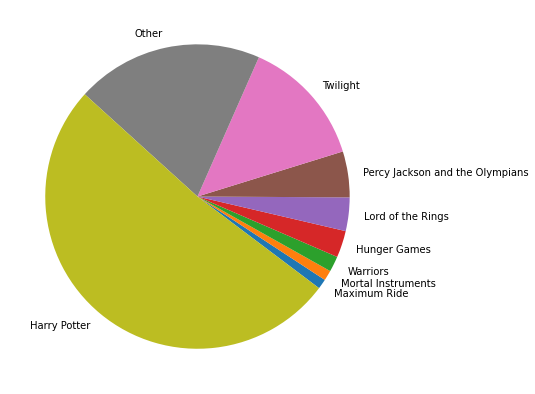

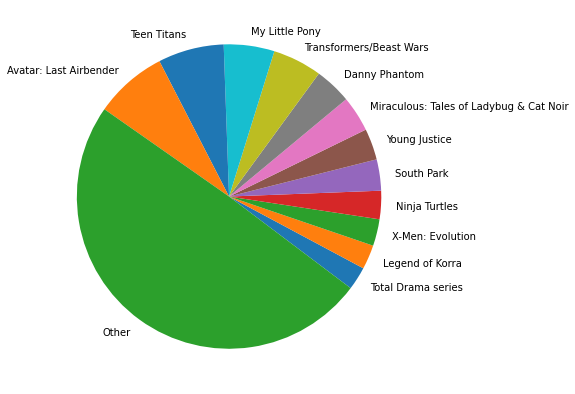

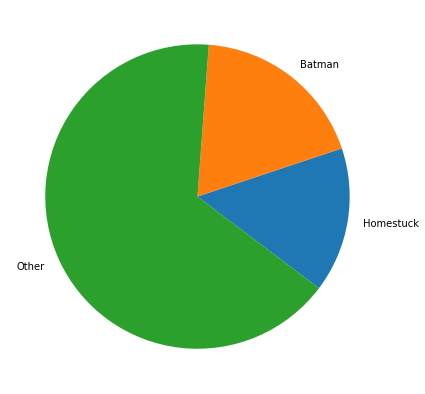

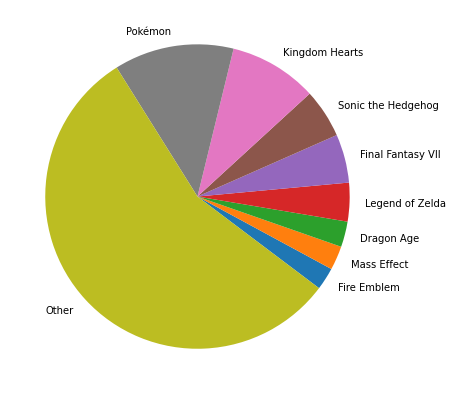

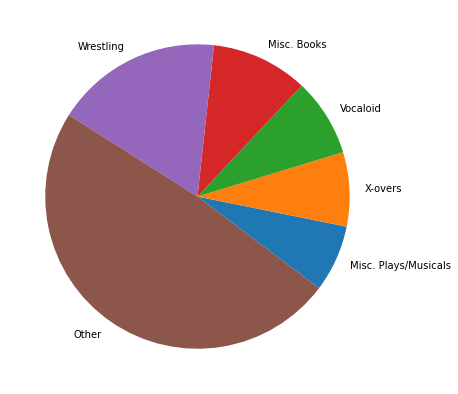

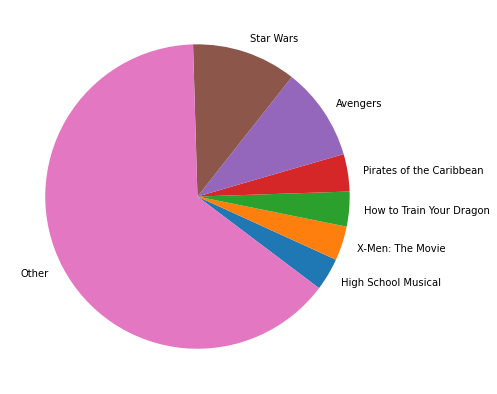

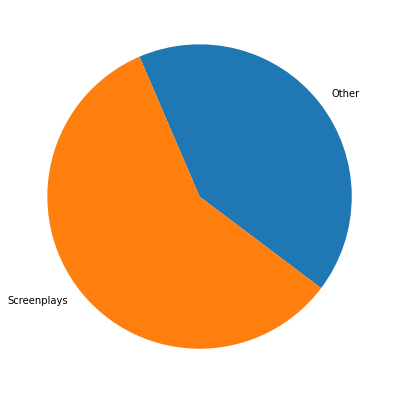

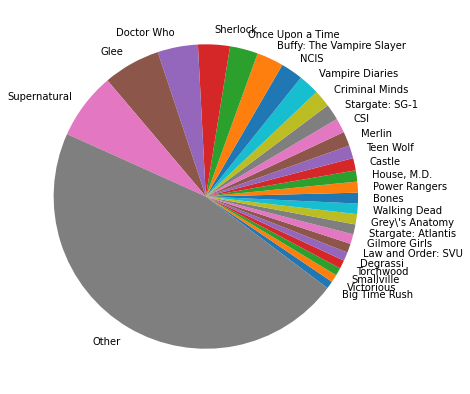

In [147]:
for t in STANDARD:
    ts = t[:-1]
    fs = dfOTHER[dfOTHER['type']==ts].sort_values('count').index
    cs = list(dfOTHER[dfOTHER['type']==ts].sort_values('count')['count'])
    fig1,ax1 = plt.subplots(figsize=(7,7))
    ax1.pie(cs, labels=fs,startangle=-37)
    plt.show()

# Iterating through fandoms

fandomL = []
titleL = []
hrefL = []
completeL = []
reviewL = []
summaryL = []
ratingL = []
languageL = []
genreAL = []
genreBL = []
chaptersL = []
wordCountL = []
reviewCountL = []
favoriteCountL = []
followCountL = []
updateDateL = []
publishDateL = []
characterListL = []

reviewSort = "?&srt=3&r=10"
favoriteSort = "?&srt=4&r=10"
followSort = "?&srt=5&r=10"
page = ["&p=1","&p=2","&p=3","&p=4","&p=5","&p=6","&p=7","&p=8","&p=9","&p=10"]

for i in range(25):
    print(df.loc[i]['fandom'],"\n")
    URLlist = []
    FANDOM_URL= "https://www.fanfiction.net" + df.loc[i]['href']
    fandomURLsorts = [FANDOM_URL + s for s in [reviewSort, favoriteSort, followSort]]
    for s in fandomURLsorts:
        for p in page:
            URLlist += [s+p]
    for URL in URLlist:
        p = soup(scraper.get(URL).text)
        for q in p.find_all("div", {"class":"z-list zhover zpointer"}):
            fandomL += [df.loc[i]['fandom']]
            titleL += [q.a.text]
            print(q.a.text)
            hrefL += [q.a.get("href")]
            reviewL += [q.find("a",{"class":"reviews"}).get("href")]
            summaryL += [re.sub("Rated: (?:K|K\+|T|M|MA).+","",q.div.text)]
            stats = re.findall("Rated: (?:K|K\+|T|M|MA).+",q.div.text)[0]
            attrs = stats.split(" - ")
            ratingL += [attrs[0].split(" ")[-1]]
            languageL += [attrs[1]]
            
            if "Chapters:" in attrs[2]:
                genreAL += [""]
                genreBL += [""]
            else:
                genre = attrs[2]
                if "Hurt/Comfort" in genre:
                    genre = re.sub("Hurt/Comfort","Hurt-Comfort", genre)
                genre = attrs[2].split("/")
                genreAL += [genre[0]]
                if len(genre) == 2:
                    genreBL += [genre[1]]
                else:
                    genreBL += [""]
            
            chaptersL += [int(re.findall("Chapters: ([0-9,]+)",stats)[0].replace(",",""))]
            wordCountL += [int(re.findall("Words: ([0-9,]+)",stats)[0].replace(",",""))]
                
            if re.findall("Reviews: ([0-9,]+)",stats) == []:
                reviewCountL += [0]
            else:
                reviewCountL += [int(re.findall("Reviews: ([0-9,]+)",stats)[0].replace(",",""))]
            
            if re.findall("Favs: ([0-9,]+)",stats) == []:
                favoriteCountL += [0]
            else:
                favoriteCountL += [int(re.findall("Favs: ([0-9,]+)",stats)[0].replace(",",""))]
            if re.findall("Follows: ([0-9,]+)",stats) == []:
                followCountL += [0]
            else:
                followCountL += [int(re.findall("Follows: ([0-9,]+)",stats)[0].replace(",",""))]
                    
            dates = [int(d.get("data-xutime")) for d in 
                     q.find("div", {"class":"z-indent z-padtop"}).find_all("span")]
            updateDateL += [datetime.fromtimestamp(dates[0])]
            if len(dates) == 1:
                publishDateL += [datetime.fromtimestamp(dates[0])]
            else:
                publishDateL += [datetime.fromtimestamp(dates[1])]
            if 'Complete' in attrs[-1]:
                completeL += [1]
                if 'Published' not in attrs[-2]:
                    characterListL += [attrs[-2].split(", ")] #needs modification for shipping
                else:
                    characterListL += [""]
            else:
                completeL += [0]
                if 'Published' not in attrs[-1]:
                    characterListL += [attrs[-1].split(", ")] #needs modification for shipping
                else:
                    characterListL += [""]
    print("\n")

dfA = pd.DataFrame(zip(fandomL,titleL,hrefL,completeL,
                    reviewL,summaryL,ratingL,languageL,
                    genreAL,genreBL,chaptersL,wordCountL,
                    reviewCountL,favoriteCountL,followCountL,
                    updateDateL,publishDateL,characterListL),
                   columns=["fandom","title","href","complete",
                            "review","summary","rating","language",
                            "genreA","genreB","chapters","wordCount",
                            "reviewCount","favoriteCount","followCount",
                            "updateDate","publishDate","characterList"],)
dfA.head(1)

#eliminating duplicates
dfA.characterList = dfA.characterList.apply("/".join)
dfA = dfA.drop_duplicates().reset_index()

dfA.to_csv('ficstats.csv')
df.to_csv('fandomstats.csv')

In [7]:
dfA = pd.read_csv('ficstats.csv', index_col=0)

<AxesSubplot:>

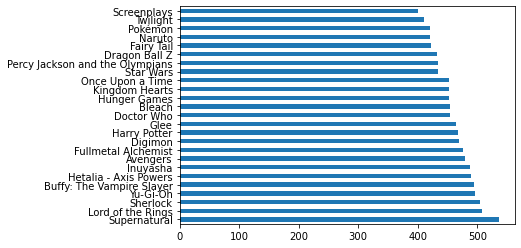

In [8]:
dfA.fandom.value_counts().plot(kind = 'barh')

<AxesSubplot:>

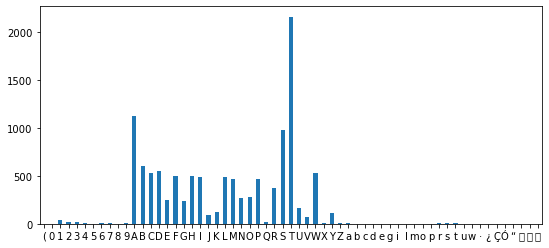

In [9]:
dfA.title.str[0].value_counts().sort_index().plot(kind='bar',figsize=(9,4),rot=0)

<AxesSubplot:>

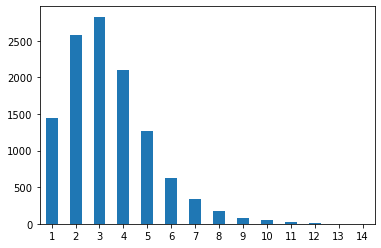

In [10]:
dfA.title.str.split(" ").apply(len).value_counts().sort_index().plot(kind='bar',rot=0)

<AxesSubplot:>

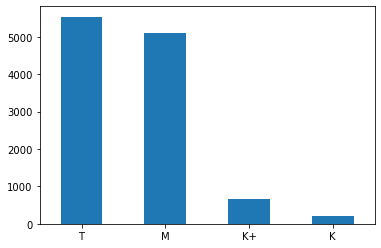

In [11]:
dfA.rating.value_counts().plot(kind='bar',rot=0)

<AxesSubplot:>

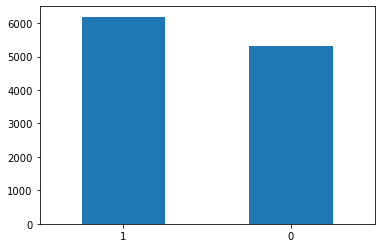

In [12]:
dfA.complete.value_counts().plot(kind='bar',rot=0)

<AxesSubplot:>

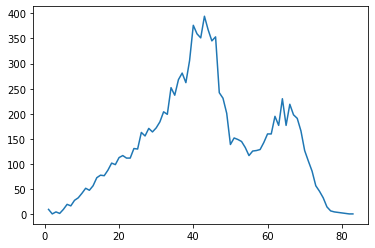

In [13]:
dfA.summary.str.split(" ").apply(len).value_counts().sort_index().plot(kind='line',rot=0)

<AxesSubplot:>

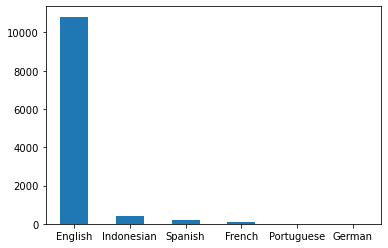

In [14]:
dfA.language.value_counts().plot(kind='bar',rot=0)

In [15]:
dfA.columns

Index(['Unnamed: 0', 'index', 'fandom', 'title', 'href', 'complete', 'review',
       'summary', 'rating', 'language', 'genreA', 'genreB', 'chapters',
       'wordCount', 'reviewCount', 'favoriteCount', 'followCount',
       'updateDate', 'publishDate', 'characterList'],
      dtype='object')